# Zonally average surface current rotary spectra

Rotary spectra need to have been computed and stored

In [1]:
import os, sys
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1)
w = cluster.scale(40)
#w = cluster.scale(5) # postprocessing

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.135.39.90:36740 Dashboard: http://10.135.39.90:8787/status,Cluster Workers: 5 Cores: 5 Memory: 200.00 GB


---
## load rotary spectra


In [5]:
v='SSUV'
# concatenates faces
#ds = xr.concat([xr.open_zarr(work_data_dir+'spectra/%s_f%02d.zarr'%(v,face))
#               .chunk({'i': 24, 'j':12}) 
#               for face in range(13)], dim='face', compat='identical')
# or load concatenated spectra
ds = xr.open_zarr(work_data_dir+'spectra/%s.zarr'%(v)) #.isel(face=slice(0,2))
ds = ds.drop(['XC', 'mask'])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1920, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>
    YC         (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<shape=(13, 1080, 1080, 1920), chunksize=(1, 12, 24, 1920)>

 data size: 233.0 GB


---

## compute the zonal average: method 1

Uses apply_ufunc, requires to use full temporal chunks

In [6]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['i','j']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [7]:
for face in range(13):
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    E = lds.SSUV.where(lds.Depth>200., drop=False)
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'spectra/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 0 done
--- face 1 done
--- face 2 done
--- face 3 done
--- face 4 done
--- face 5 done
--- face 6 done
--- face 7 done
--- face 8 done
--- face 9 done
--- face 10 done
--- face 11 done
--- face 12 done


### Reload data and finish the zonal averaging

In [8]:
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'spectra/%s_f%02d_zav.zarr'%(v,face))
                    for face in range(13)], dim='face', compat='identical').sum('face')
E_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1920, latitude: 119)>
dask.array<shape=(1920, 119), dtype=float64, chunksize=(1920, 119)>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [9]:
Efile = work_data_dir+'spectra/%s_zav.zarr'%(v)
%time E_zav.to_dataset().to_zarr(Efile, mode='w')

CPU times: user 304 ms, sys: 19.1 ms, total: 323 ms
Wall time: 349 ms


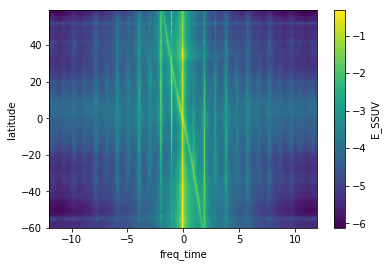

In [10]:
np.log10(E_zav).plot(x='freq_time', y='latitude')

In [ ]:
# clean up tmp dir
from shutil import rmtree
for face in range(13):
    rmtree(work_data_dir+'spectra/%s_f%02d_zav.zarr'%(v,face))

### method 2bis: works for 1 face but not all

Should subdivide into two cases: 1 face, multiple faces which require stacking

In [ ]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zaverage(x, lat):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    h, edges = np.histogram(lat, bins=latb, weights=x, density=False)
    return h[None,:]

def get_E_zav(v, **kwargs):
    #dims = ['i','j']
    #dims = ['i','j','face']
    dims = ['point']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    E = xr.apply_ufunc(_zaverage, v, lat,
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',                       
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    return E.assign_coords(latitude=latc).rename('E_SSUV')

In [ ]:
#ds = ds.stack(point=['face', 'j', 'i']).chunk({'freq_time':10, 'point':10000})
E = ds.SSUV.where(ds.Depth>200., drop=False)
#E = E.chunk({'i': None, 'j': None, 'freq_time':1}).persist()
E = E.chunk({'i': None, 'j': None, 'face':None, 'freq_time':1}).persist() # for all faces
print(E)

In [ ]:
E_zav = get_E_zav(E)
print(E_zav)
Efile = work_data_dir+'spectra/%s_zav.zarr'%(v)
%time E_zav.chunk({'latitude':None}).to_dataset().to_zarr(Efile, mode='w')

In [ ]:
del E
del ds

In [ ]:
cluster.close()

---

## compute the zonal average: method 2

Inspired from [Ryan's notebook](https://gist.github.com/rabernat/fd2522f1937a43f49ac0423d35915648)

Does not work for all faces

In [ ]:
ds = ds.stack(point=['face', 'j', 'i']).chunk({'freq_time':10, 'point':7200}).persist()
print(ds)

In [ ]:
dlat=1.
E_zav = (ds.SSUV.where(ds.Depth>200., drop=False)
         .groupby_bins(ds.YC, np.arange(-60-dlat/2., 60+dlat, dlat),
                        labels=np.arange(-60, 60+dlat, dlat))
         .mean(dim=['point']))
E_zav = (E_zav.rename('E_SSUV').rename({'YC_bins': 'latitude'})
         .chunk({'latitude':None}))
Efile = work_data_dir+'spectra/%s_zav.zarr'%(v)
print(E_zav)
%time E_zav.to_dataset().to_zarr(Efile, mode='w')

In [ ]:
cluster.close()

---
# inspect result

In [12]:
E = xr.open_zarr(work_data_dir+'spectra/%s_zav.zarr'%(v))['E_SSUV'].fillna(0.)
E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'E_SSUV' (freq_time: 1920, latitude: 119)>
dask.array<shape=(1920, 119), dtype=float64, chunksize=(1920, 119)>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5

 data size: 0.0 GB


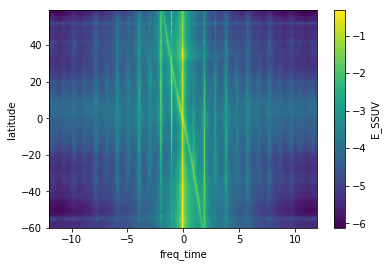

In [13]:
np.log10(E).plot(x='freq_time',y='latitude')

---

In [ ]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [6]:
cluster.close()